# Fitting a symbolic regression for the edge messages learned for each edge (take the last epoch)

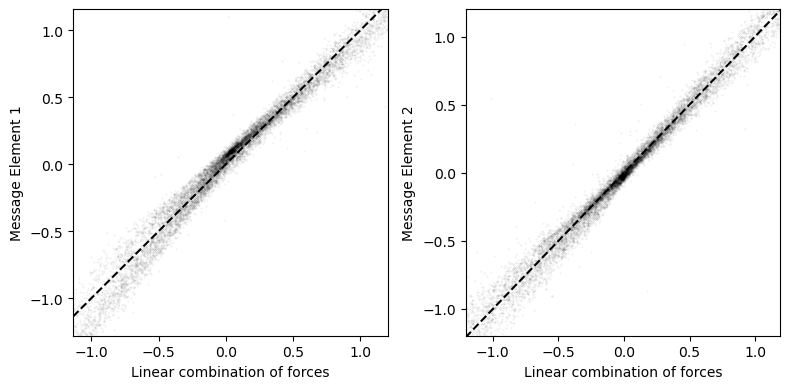

In [5]:
# First let's plot the final epoch: message elements and linear combination of true forces

from pysr import PySRRegressor 
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import sys
import os
from analyze import linear_transformation_2d, out_linear_transformation_2d
from scipy.optimize import minimize


# Plot the learned message elements of the last epoch vs the linear combination (transformation) of true forces
msg_dim = 100
dim = 2
fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))


# Load the message data from the trained model - this also includes the node embedding for receiving and sending nodes
messages_over_time = pkl.load(open("models/messages_over_time.pkl", "rb"))

# Select the last element of the list corresponding to the final epoch
last_message = messages_over_time[-1]
last_message['bd'] = last_message.r + 1e-2


try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(last_message[msg_columns])
except:
    msg_columns = ['e%d'%(k) for k in range(msg_dim)]
    msg_array = np.array(last_message[msg_columns])
msg_importance = msg_array.std(axis=0)
most_important = np.argsort(msg_importance)[-dim:]
msgs_to_compare = msg_array[:, most_important]
msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)
pos_cols = ['dx', 'dy']
force_fnc = lambda msg: -(msg.bd.values - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd.values[:, None]
expected_forces = force_fnc(last_message)

min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')

for i in range(dim):
   
    px = out_linear_transformation_2d(min_result.x)[i]

    py = msgs_to_compare[:, i]
    ax[i].scatter(px, py,
                    alpha=0.1, s=0.1, color='k')
    ax[i].set_xlabel('Linear combination of forces')
    ax[i].set_ylabel('Message Element %d'%(i+1))

    xlim = np.array([np.percentile(px, q) for q in [10, 90]])
    ylim = np.array([np.percentile(py, q) for q in [10, 90]])
    xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
    ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
                
    plt.tight_layout()
    
# Plot a y=x line
for i in range(dim):
    ax[i].plot(ax[i].get_xlim(), ax[i].get_xlim(), 'k--')


plt.show()



In [16]:
# Create the symbolic regression model and train it
model = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    #unary_operators=["exp", "abs", "sqrt"],
    elementwise_loss="f(x, y) = abs(x - y)"
)


# Load the message data from the trained model - this also includes the node embedding for receiving and sending nodes
messages_over_time = pkl.load(open("models/messages_over_time.pkl", "rb"))

# Select the last element of the list corresponding to the final epoch
last_message = messages_over_time[-1]

# Find the most significant elements of the learned message vector
# Calculate the two with the largest standard deviation

# Calculate the standard deviations for each set of values
std_deviations = [np.std(messages_over_time[-1]['e%d' % i]) for i in range(100)]

# Sort the standard deviations in descending order and get the indices of the first two elements
best_indices = np.argsort(std_deviations)[::-1][:2]

# Extract the best messages
best_messages = last_message[['e%d'%(best_indices[0],), 'e%d'%(best_indices[1],), 'dx', 'dy', 'r', 'm1', 'm2']]

# Add small values to the r values to avoid division by zero
# best_messages['r'] = best_messages['r'] + 0.0001


best_messages




,e39,e65,dx,dy,r,m1,m2
0,-0.006713,-0.148440,0.387275,1.452278,1.503028,2.868710,0.705558
1,-0.012089,0.022596,0.734112,0.334981,0.806928,2.868710,0.672428
2,-0.049591,-0.011670,0.993327,-0.182153,1.009890,2.868710,0.681020
3,-0.086172,0.133796,-0.387275,-1.452278,1.503028,0.705558,2.868710
4,-0.079918,0.034296,0.346837,-1.117297,1.169892,0.705558,0.672428
...,...,...,...,...,...,...,...
7,-0.180168,-0.041636,1.303372,-0.459186,1.381894,0.182907,3.269928
8,-0.036571,-0.097086,-0.233634,-0.569561,0.615618,0.182907,0.509599
9,-0.095421,0.214320,-0.506592,-1.703316,1.777054,0.509599,1.891710
10,-0.204517,-0.129285,1.537007,0.110375,1.540965,0.509599,3.269928


In [17]:
# Now, let's fir e39 and e65 as a function of dx, dy, r, m1, and m2

F1 = best_messages['e%d'%(best_indices[0],)]
F2 = best_messages['e%d'%(best_indices[1],)]

# First fit the highest standard deviation element
model.fit(best_messages[['dx', 'dy', 'r', 'm1', 'm2']], F1)


/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1877: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  warnings.warn(
[ Info: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (`options.batching`), and also if you need that many datapoints. Unless you have a large amount of noise (in which case you should smoo


Expressions evaluated per second: 1.540e+04
Head worker occupation: 10.7%
Progress: 40 / 1500 total iterations (2.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           1.008e-01  5.314e+00  y = -0.10339 * dx
5           8.603e-02  7.905e-02  y = -0.06095 * (dx * r)
7           6.613e-02  1.315e-01  y = -0.067332 * ((r * dx) - dy)
9           5.252e-02  1.152e-01  y = -0.067332 * (((r * dx) + 0.61522) - dy)
13          5.149e-02  4.942e-03  y = ((((-0.16016 + -0.41378) + dy) - (dx * r)) * 0.045658) / 0...
                                  .69993
15          5.124e-02  2.417e-03  y = (((((-0.16016 + -0.253) - 0.19152) + dy) - (dx * r)) * 0.0...
                                  45658) / 0.69993
17          4.984e-02  1.383e-02  y = (((r + -0.04316) * 1.7625) * (0.02255 * ((-1.0673 - (dx / ...
                                  0.61201)) + dy))) / 1.0623
19          3.82

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                       -0.045672182   
	1        0.113139                                  dx * -0.103388324   
	2        0.079069                            (dx * -0.060511768) * r   
	3        0.141759                     ((dx * r) - dy) * -0.060511768   
	4        0.135997      (((dx * r) - dy) - -0.7703175) * -0.060511768   
	5        0.097085  (((dx - (dy * 0.55660975)) * r) - -0.79010415)...   
	6        0.006041  -0.059694 * (((dx - (-0.7478578 / r)) - (dy * ...   
	7  >>>>  0.566033  ((r - 0.97756207) * ((dy + (dx / -0.553161)) /...   
	8        0.057841  (((dy + (dx / -0.5403469)) / ((r / 0.14001885)...   
	9        0.015297  (((dy + ((dx / -0.5403469) + -0.028379802)) / ...   
	
	       loss  complexity  
	0  0.126351           1  
	1  0.100764           3  
	2  0.086026           5  
	3  0.064789           7  
	4  0.049360           9  
	5  0.040649          11  
	6  0.040161          13  
	7  0.012946          15  
	8  0.011532          17  
	9  0.011185          19  
]

In [20]:
print("The best symbolic formulation is found to be: ")
model.sympy()

The best symbolic formulation is found to be: 


-0.04384377 + 0.14444424*(-1.80779194484065*dx + dy)*(r - 0.97756207)/r

In [21]:
# Next fit the second highest standard deviation element
model.fit(best_messages[['dx', 'dy', 'r', 'm1', 'm2']], F2)


/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1843: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/pysr/sr.py:1877: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  w


Expressions evaluated per second: 1.890e+04
Head worker occupation: 16.7%
Progress: 51 / 1500 total iterations (3.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.006e+00  1.594e+01  y = dy
3           9.415e-02  1.184e+00  y = -0.082178 * dy
5           7.219e-02  1.328e-01  y = -0.081718 * (dy + dx)
7           5.071e-02  1.766e-01  y = (-0.048844 * (dx + dy)) * r
9           4.322e-02  7.998e-02  y = r * (-0.058994 * (dy - (dx / -1.3456)))
11          3.726e-02  7.417e-02  y = r * ((dy - ((0.21595 + dx) / -1.6551)) * -0.058994)
13          3.532e-02  2.670e-02  y = ((dy + (((dx + -0.062038) * 0.67095) - -0.22769)) * -0.055...
                                  595) * r
15          3.240e-02  4.320e-02  y = (-0.049785 * ((dx + ((dy * 0.47903) - -0.29334)) + dy)) * ...
                                  (r - 0.47903)
19          3.221e-02  1.482e-03  y = (-0.05

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                      -0.0042638066   
	1        0.116691                                   dy * -0.08236671   
	2        0.133005                           (dy + dx) * -0.080055274   
	3        0.183300                     (-0.045363374 * (dx + dy)) * r   
	4        0.110192        (-0.05435812 * ((dx / 1.5485686) + dy)) * r   
	5        0.063725  (((0.18814132 + dy) + (dx * 0.67095023)) * -0....   
	6        0.058181  (0.8610977 - ((1.7431223 - r) / r)) * (-0.1001...   
	7  >>>>  0.165083  (0.84293264 - ((1.7431223 - r) / r)) * ((dx + ...   
	8        0.061365  (0.8448948 - ((1.7398936 - r) / r)) * (((dy * ...   
	9        0.049640  ((0.84293264 - ((1.7431223 - r) / r)) - (dx * ...   
	
	       loss  complexity  
	0  0.118902           1  
	1  0.094153           3  
	2  0.072162           5  
	3  0.050014           7  
	4  0.040122           9  
	5  0.035321          11  
	6  0.031441          13  
	7  0.022600          15  
	8  0.019990          17  
	9  0.018100          19  
]

In [22]:
print("The best symbolic formulation is found to be: ")
model.sympy()

The best symbolic formulation is found to be: 


(0.84293264 - (1.7431223 - r)/r)*(-0.10011584*dx - 0.12613734843776*dy)